# Классификация (прогозирование классов)
## Обучение с учителем


In [1]:
import numpy as np
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [2]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]



(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [3]:
X,y = mnist['data'], mnist['target']
# 70.000 изображений и 784 признака
# Каждый признак представляет иннтесивность пикселя
# от 0(белый) до 255(черный)

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [5]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

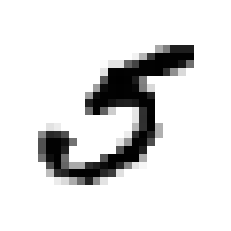

In [6]:
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, \
          interpolation='nearest')
plt.axis('off')
plt.show()

In [7]:
# Создадим испытальный набор
X_train, X_test, y_train, y_test = \
    X[:60000],X[60000:],y[:60000],y[60000:]

In [8]:
# Перетасовка обучающегося набора
shaffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shaffle_index],y_train[shaffle_index]

## Двоичный классификатор

In [9]:
y_train_5 = (y_train == 5) #True для все пятёрок
y_test_5 = (y_test == 5) #False для всех остальных цифр

Стохастический градиентый спуск (Stochastic Gradient Descent - SGD)

In [10]:
from sklearn.linear_model import SGDClassifier

In [11]:
sgd_clf = SGDClassifier( random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

# Показатели производительности
### Насколько хорошо работает классификатор (способы оценки)

### Реализация перекрестной проверки 

In [13]:
from sklearn.model_selection import StratifiedKFold #для стратифицированной выборки
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9562
0.95905
0.9697


In [14]:
# accuracy-коэффицинт корректных прогнозов
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9562 , 0.95905, 0.9697 ])

In [15]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9094 , 0.9099 , 0.90965])

Ассиметричные наборы -это когда одни классы встречаются чаще других

### Матрица неточностей

Общая идея заключается в том, чтобы подсчитать, сколько раз образцы класса А были отнесены к классу В. Например, для выяснения, сколько раз классифи­катор путал изображения пятерок с тройками, вы могли бы заглянуть в 5-ю строку и 3-й столбец матрицы неточностей. 

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[54293,   286],
       [ 2015,  3406]], dtype=int64)

Каждая строка в матрице неточностей представляет фактический класс, а каждый столбец - спрогнозированный класс. Первая строка матрицы учи­тывает изображения не пятерок (отрицательньtй класс (negative class)): 53 309 их них были корректно классифицированы как не пятерки (истинно отрицательные классификации (trиe negative - TN)), тогда как оставшиеся 1 270 были ошибочно классифицированы как пятерки (ложноположительные классификации (false positive - FP)). Вторая строка матрицы учитывает изоб­ражения пятерок (положительный класс class)): 947 были ошибоч­но классифицированы как не пятерки (ложноотрицательные классификации negative - FN) ), в то время как оставшиеся 4 474 были корректно клас­сифицированы как пятерки (истинно положительные классификации positive - ТР)).

In [18]:
# Точность Precision
4474/(4474+1270)

0.778899721448468

In [19]:
# Полнота Recall/чувствительность/Доля истинно положительных классификаторов
4474/(4474+947)

0.8253089835823649

Вывод: изображение представляет петерку, корректно на 77%, кроме того, от обнаруживает только 82% пятерок.

### Точность и полнота = Мера F1(F1 score)

In [20]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) #точность

0.9225352112676056

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7475035663338088

Нельзя получить одновременно высокую и полному и точность: увеличение точности снижает полноту и наоборот.

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores  #Порог принятия решения

array([4247.50821645])

In [23]:
threshold = 4600
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Поднятие порога снижает полноту

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

Вычисляем точность и полному

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

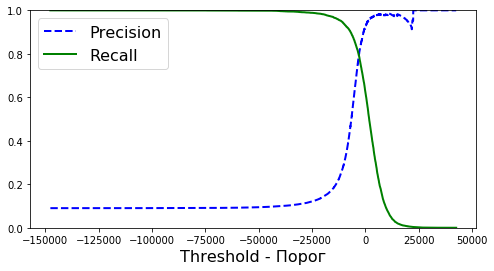

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold - Порог", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [27]:
(y_train_pred == (y_scores > 0)).all()

True

In [28]:
y_train_pred_90 = (y_scores > 0)

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9225352112676056

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.6282973621103117

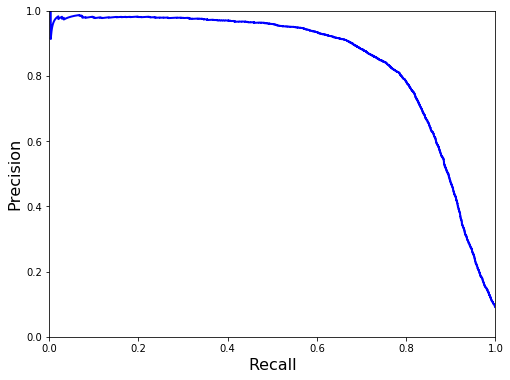

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Кривая ROC (рабочей характеристики приемника)

Кривая рабочей характеристики приемника (Receiver Operatiпg Characteristic­ROC) представляет собой еще один распространенный инструмент, при­меняемый с двоичными классификаторами. Она очень похожа на кривую точности-полноты (precisioп-recall (PR) cиrve), но вместо вычерчивания точности в сравнении с полнотой кривая ROC изображает долю истинно положительных классификаций (другое название полноты) по отношению к доле ложноположительных классификаций (False Positive Rate - FPR). Доля FPR - это пропорция отрицательных образцов, которые были некоррект­но классифицированы как положительные. Она равна единице минус доля истинно отрицательных классификаций (Тrие Negative Rate - TNR), пред­ставляющая собой пропорцию отрицательных образцов, которые были кор­ректно классифицированы как отрицательные. 
Доля TNR также называется специфичностью (specificity). Следовательно, кривая ROC изображает чувствительность (seпsitivity), т.е. полноту, в срав­нении с 1- специфичность. 

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

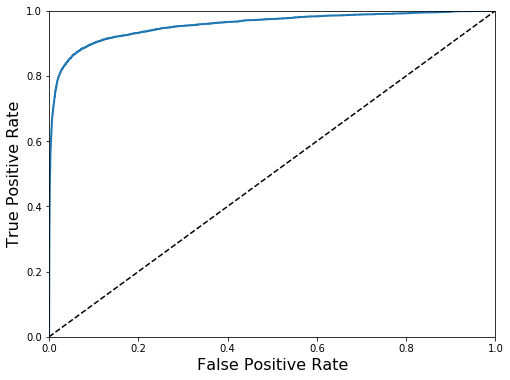

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [34]:
#измерение площади под кривой, идеал 1
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.956267291913819

In [35]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [36]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

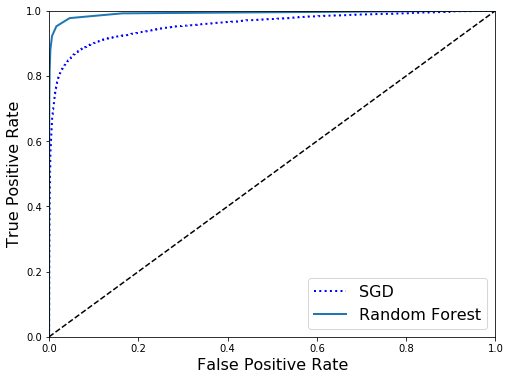

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920161930149171

Измерение точности и полноты при random_forest

In [39]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9830172033524481

In [40]:
recall_score(y_train_5, y_train_pred_forest)

0.8221730308061244

# Многомерная классификация

In [41]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [42]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -9530.78157133, -20012.02701083,  -7424.36716475,
         -3494.59716673, -17944.38255952,  -1089.05005909,
        -33039.87960083, -23114.39844568, -11574.73390535,
        -14599.30534269]])

In [43]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

#### Тестирование стратегий OneVsRestClassifier(OvA) и OneVsOneClassifier(Ovo).
Регультат- отрицательный (должно было показать 5)

In [44]:
from sklearn.multiclass import OneVsRestClassifier
ova_clf = OneVsRestClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ova_clf.fit(X_train, y_train)
ova_clf.predict([some_digit])

array([5], dtype=int8)

In [45]:
len(ova_clf.estimators_)

10

In [46]:
ova_clf.decision_function([some_digit])

array([[  -8637.44530828, -376100.04278429, -207311.55777462,
        -336385.80976179, -544495.52437493,  199191.51858093,
        -746908.4343769 , -283148.40922216, -736423.44362348,
        -783153.84057047]])

In [47]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [48]:
ovo_clf.decision_function([some_digit])[:6]

array([[7.33333329, 4.66666679, 4.66666682, 8.33333329, 1.66666675,
        9.33333331, 1.6666667 , 4.33333305, 0.66666672, 1.66666671]])

In [49]:
len(ovo_clf.estimators_)

45

In [50]:
# Обучение RandomForestCl
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [51]:
# Смотрим вероятность выбора
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [52]:
# Анализ ошибок
for i in [sgd_clf, ova_clf, ovo_clf, forest_clf]:
    print(cross_val_score(i, X_train, y_train, cv=3, scoring="accuracy"))

[0.8694761  0.8820441  0.88378257]
[0.85717856 0.86884344 0.87233085]
[0.91566687 0.91134557 0.89643447]
[0.94246151 0.94294715 0.93964095]


In [53]:
#Улучшение модели
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90411918, 0.90169508, 0.90293544])

# Анализ ошибок

In [54]:
%%time
# Матрица неточностей
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

Wall time: 15min 49s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5603,    0,   13,    8,    8,   47,   36,    5,  202,    1],
       [   0, 6420,   44,   21,    4,   43,    5,    7,  185,   13],
       [  26,   24, 5280,   85,   74,   24,   67,   36,  331,   11],
       [  31,   21,  117, 5258,    1,  211,   23,   44,  356,   69],
       [  10,   16,   46,   13, 5270,    8,   37,   14,  264,  164],
       [  29,   18,   33,  165,   55, 4485,   77,   19,  477,   63],
       [  29,   20,   50,    3,   42,   95, 5548,    5,  126,    0],
       [  18,   15,   55,   23,   55,   12,    5, 5711,  147,  224],
       [  17,   63,   42,   94,    2,  122,   30,   10, 5423,   48],
       [  23,   21,   27,   57,  128,   36,    1,  176,  303, 5177]],
      dtype=int64)

In [55]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

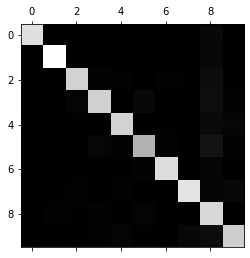

In [56]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Строки - Истеное значение
Столбцы - Прогнозируемое
Чем более светлая ячейка, тем больше в выборке истиных значений

In [57]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Типы ошибок, которые допускает классификатор.

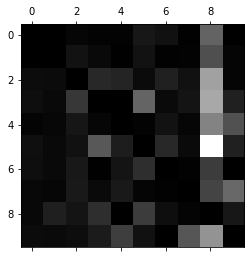

In [59]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [66]:
import matplotlib as mpl
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

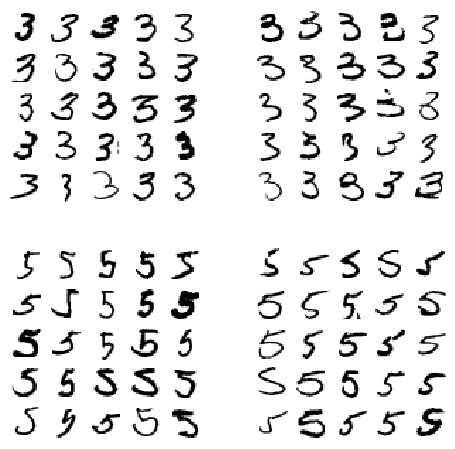

In [67]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# Многозначная классификация